<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
import re
import os

!pip install subgroups

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [14]:
#SDUEBA Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""

vector_space_dimention = 36
n_clusters = 23
max_depth = 2
test_size = 0.2
mixed_threshold = 0.9

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 10


In [15]:
#Data augemntation

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mapping_targets = {'p': 'poisonous', 'e': 'edible'}

data = fetch_ucirepo(id=73)
features_raw = preprocess_mushroom_data(pd.DataFrame(data=data.data.features))
target_df = pd.DataFrame(data=data.data.targets)
target_df.columns = ['class']
target_df['class'] = target_df['class'].map(mapping_targets)
# features_raw.head()

In [16]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

In [17]:
#Word2Vec training and clustering
def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=vector_space_dimention, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])
labels_agglomerative_average = AgglomerativeClustering(n_clusters= n_clusters, metric = 'cosine', linkage='average').fit_predict(embeddings)

In [18]:
#Classification trees training
features_classify = features_raw.assign(cluster=labels_agglomerative_average)

encoder = OneHotEncoder()
X = features_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(X)
y = features_classify['cluster']
X_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=test_size, random_state=73, stratify=y)

decision_trees = {}
accuracies = {}

for cluster in sorted(y.unique()):
    # print(f"Training Decision Tree for Cluster {cluster}...")

    y_train_binary = (y_train == cluster).astype(int)
    y_test_binary = (y_test == cluster).astype(int)

    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=subgroup_size_limit, random_state=73)
    clf.fit(X_train, y_train_binary)

    decision_trees[cluster] = clf

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test_binary, y_pred)
    accuracies[cluster] = accuracy

    print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
    print(classification_report(y_test_binary, y_pred))


Accuracy for Cluster 0: 0.9902
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1599
           1       1.00      0.38      0.56        26

    accuracy                           0.99      1625
   macro avg       1.00      0.69      0.78      1625
weighted avg       0.99      0.99      0.99      1625

Accuracy for Cluster 1: 0.9988
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1623
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1625
   macro avg       0.50      0.50      0.50      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy for Cluster 2: 0.9969
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1619
           1       0.60      0.50      0.55         6

    accuracy                           1.00      1625
   macro avg       0.80      0.75  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1587
           1       1.00      1.00      1.00        38

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy for Cluster 4: 0.9902
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1567
           1       1.00      0.72      0.84        58

    accuracy                           0.99      1625
   macro avg       0.99      0.86      0.92      1625
weighted avg       0.99      0.99      0.99      1625

Accuracy for Cluster 5: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1279
           1       1.00      1.00      1.00       346

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for Cluster 21: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       102

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy for Cluster 22: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1587
           1       1.00      1.00      1.00        38

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [32]:
#Subgroup creation and quality evaluation

def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - TP / (TP + FP)) if (tp + fp) > 0 and (TP + FP) > 0 else np.NaN
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    else:
        return difference / description_length

class Subgroup_creator:
    def __init__(self, data_frame, target_df, mixed_threshold, cluster_labels, feature_names, decision_trees):
        self.data_frame = data_frame
        self.target_df = target_df
        self.mixed_threshold = mixed_threshold
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.description_length_dict = {}
        self._classify_and_extract_rules()
    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            class_probabilities = value[0] / value.sum()
            predicted_class = class_probabilities.argmax()
            if predicted_class == 1:
                rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _classify_and_extract_rules(self):
        cluster_class_counts = {}
        for i, cluster in enumerate(self.cluster_labels):
            class_label = self.target_df['class'][i]
            cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
            cluster_class_counts[cluster][class_label] += 1

        N = len(self.target_df)
        class_counts = {class_: sum(self.target_df['class'] == class_) for class_ in set(self.target_df['class'])}
        cluster_classifications, n_dict = {}, {}


        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}
            dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
            relative_frequency = dominant_count / total_count
            classification = dominant_class if relative_frequency >= self.mixed_threshold else 'mixed'

            cluster_classifications[cluster] = classification
            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = class_percentages
            self.tp_dict[cluster] = dominant_count
            self.fp_dict[cluster] = total_count - dominant_count
            n_dict[cluster] = total_count


            self.TP_dict[cluster] = class_counts[dominant_class]
            self.FP_dict[cluster] = N - class_counts[dominant_class]

            self.WRAcc_dict[cluster] = ((self.tp_dict[cluster] + self.fp_dict[cluster]) / N) * (self.tp_dict[cluster] / n_dict[cluster] - self.TP_dict[cluster] / N)
            if cluster in self.decision_trees:
                rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                if rules_list:
                    self.rules_dict[cluster] = rules_list
                    self.description_length_dict[cluster] = len(self.rules_dict[cluster])
                else:
                    self.description_length_dict[cluster] = np.NAN
            else:
                self.unextractable_clusters.append(cluster)

            self.Quality_dict[cluster] = Quality_metric(tp=self.tp_dict[cluster],
                                                        fp=self.fp_dict[cluster],
                                                        TP=self.TP_dict[cluster],
                                                        FP=self.FP_dict[cluster],
                                                        description_length=self.description_length_dict[cluster],
                                                        description_length_limit=description_length_limit,
                                                        difference_limit=difference_limit,
                                                        subgroup_size_limit=subgroup_size_limit)

            if cluster in self.decision_trees:
                rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                if rules_list:
                    self.rules_dict[cluster] = rules_list
                    self.description_length_dict[cluster] = len(self.rules_dict[cluster])
                else:
                    self.unextractable_clusters.append(cluster)
                    self.description_length_dict[cluster] = np.NAN
            else:
                self.unextractable_clusters.append(cluster)


    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items())
            rules = self.rules_dict.get(cluster, ["No rules extracted"])
            print(f"Cluster {cluster}: support = {self.cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {self.WRAcc_dict[cluster]}, Quality metric = {self.Quality_dict[cluster]}")
            for rule in rules:
                print(f"  - {rule}")
        print("\nUnextractable Clusters:", self.unextractable_clusters)



subgroups = Subgroup_creator(
    data_frame=features_df,
    target_df=target_df,
    mixed_threshold=mixed_threshold,
    cluster_labels=labels_agglomerative_average,
    feature_names=list(X_df.columns),
    decision_trees=decision_trees
)
subgroups.print_summary()



Formatted Cluster Summary:
Cluster 0: support = 128, 'edible': 1.0, WRAcc = 0.015507540556141015, Quality metric = 0.9842442146725751
  - spore-print-color_purple > 0.50
Cluster 1: support = 8, 'poisonous': 1.0, WRAcc = 0.0009837668768262295, Quality metric = nan
  - No rules extracted
Cluster 2: support = 32, 'poisonous': 1.0, WRAcc = 0.0039234310336509854, Quality metric = 0.9960610536681438
  - stalk-color-below-ring_yellow > 0.50
Cluster 3: support = 192, 'edible': 1.0, WRAcc = 0.0230751272557486, Quality metric = 0.9763663220088626
  - stalk-root_rooted > 0.50
Cluster 4: support = 288, 'edible': 0.33, 'poisonous': 0.67, WRAcc = 0.022795851888054216, Quality metric = 0.32151649433776464
  - odor_creosote <= 0.50 AND cap-shape_sunken > 0.50
  - odor_creosote > 0.50
Cluster 5: support = 1728, 'poisonous': 1.0, WRAcc = 0.16746049235374588, Quality metric = 0.7872968980797637
  - gill-color_buff > 0.50
Cluster 6: support = 48, 'edible': 1.0, WRAcc = 0.005873510076822545, Quality metri

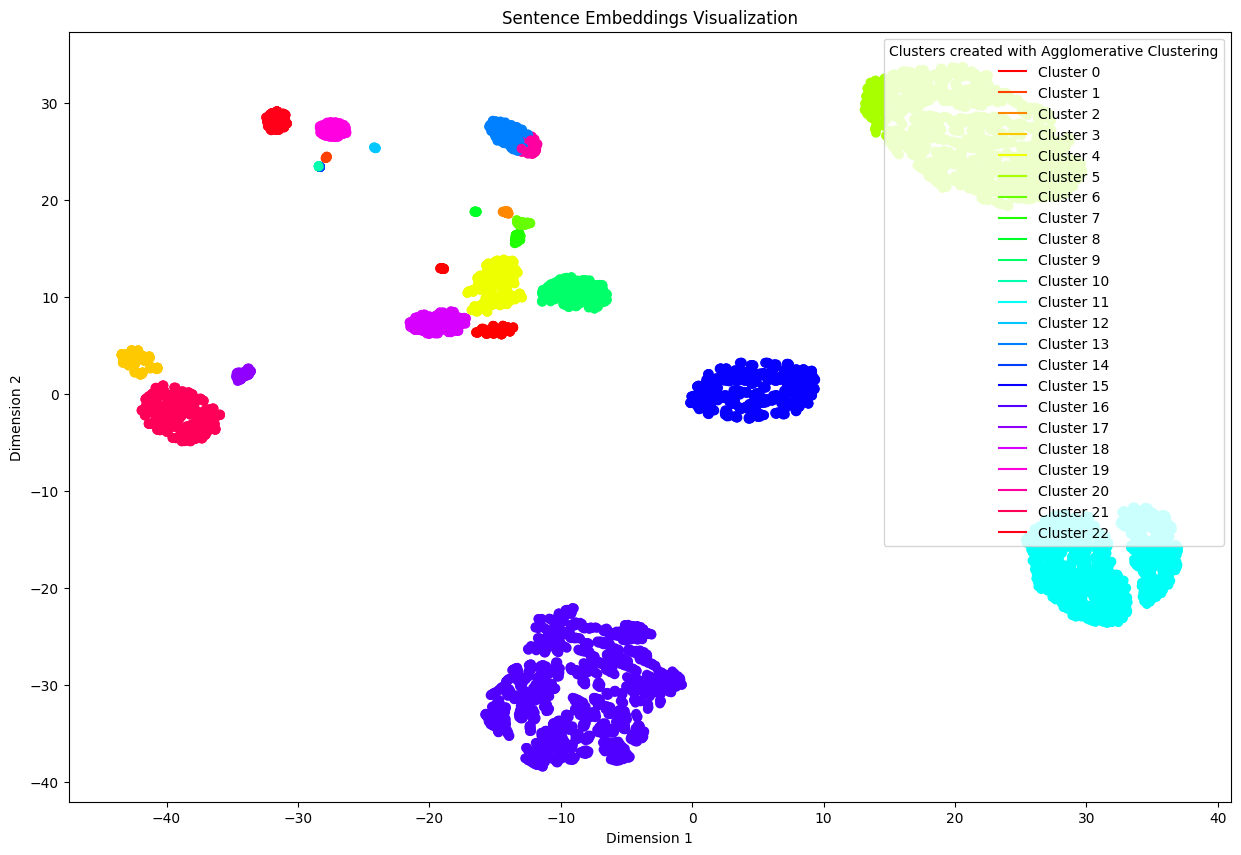

In [24]:
#Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    if cluster_labels is not None and target_labels is None:
        n_clusters = len(set(cluster_labels))
        colors = cmap(np.linspace(0, 1, n_clusters))
        handles = [plt.Line2D([], [], color=color) for color in colors]
        labels = [f"Cluster {i}" for i in range(n_clusters)]
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

        plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")

    elif target_labels is not None and cluster_labels is None:

        edible_color = 'green'
        poisonous_color = 'red'

        colors = [edible_color if label == 'edible' else poisonous_color for label in target_labels]

        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
        handles = [plt.Line2D([], [], color=edible_color, label='Edible'), plt.Line2D([], [], color=poisonous_color, label='Poisonous')]

        labels = ['Edible', 'Poisonous']

        plt.legend(handles=handles, labels=labels, title="Classes", loc="upper right")


    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(sentences)), cmap=cmap)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels_agglomerative_average, clustering_method='Agglomerative Clustering')

In [25]:
%%time
from subgroups.algorithms import BSD
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1

dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
target = ('class', 'edible')

bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=23, max_depth=4, write_results_in_file = True, file_path = "./results_BSD.txt" )
bsd_model.fit(dataset, target)


CPU times: user 2min 3s, sys: 5.29 s, total: 2min 8s
Wall time: 2min 14s


In [28]:
subgroups_to_read = 10
with open("./results_BSD.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [gill-spacing = 'close', odor = 'none'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13007444191593573 ; tp = 2304 ; fp = 104 ; TP = 4208 ; FP = 3916
Description: [gill-spacing = 'close', odor = 'none', stalk-surface-above-ring = 'smooth', veil-type = 'partial'], Target: class = 'edible' ; Quality Measure WRAcc = 0.1311653613209919 ; tp = 2288 ; fp = 72 ; TP = 4208 ; FP = 3916
Description: [bruises = 'bruises', stalk-surface-above-ring = 'smooth'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13268295142669229 ; tp = 2752 ; fp = 480 ; TP = 4208 ; FP = 3916
Description: [odor = 'none', ring-type = 'pendant'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13445266512822787 ; tp = 2352 ; fp = 80 ; TP = 4208 ; FP = 3916
Description: [ring-type = 'pendant', stalk-surface-above-ring = 'smooth'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13468151577675525 ; tp = 2992 ; fp = 672 ; TP = 4208 ; FP = 3916
Description: [ring-type = 'pendant'], Target

In [33]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), (Target: .*? ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+))", line)

            if match:
                description = match.group(1)
                details = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                print(f"{description}, {details} ; Quality Metric = {quality_score if not np.isnan(quality_score) else 'NaN'}")

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)


Description: [gill-spacing = 'close', odor = 'none'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13007444191593573 ; tp = 2304 ; fp = 104 ; TP = 4208 ; FP = 3916 ; Quality Metric = 0.21941959429507096
Description: [gill-spacing = 'close', odor = 'none', stalk-surface-above-ring = 'smooth', veil-type = 'partial'], Target: class = 'edible' ; Quality Measure WRAcc = 0.1311653613209919 ; tp = 2288 ; fp = 72 ; TP = 4208 ; FP = 3916 ; Quality Metric = NaN
Description: [bruises = 'bruises', stalk-surface-above-ring = 'smooth'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13268295142669229 ; tp = 2752 ; fp = 480 ; TP = 4208 ; FP = 3916 ; Quality Metric = 0.16675685293787873
Description: [odor = 'none', ring-type = 'pendant'], Target: class = 'edible' ; Quality Measure WRAcc = 0.13445266512822787 ; tp = 2352 ; fp = 80 ; TP = 4208 ; FP = 3916 ; Quality Metric = 0.22456691025940034
Description: [ring-type = 'pendant', stalk-surface-above-ring = 'smooth'], Target: class = 'edibl